# Initial EDA for Mercedes Test Bench Data Set

import libraries


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

## 1. Load the data

In [21]:
#Load datasets as pandas DF 
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# inspect data
train_df.head()
test_df.head()

Train shape: (4209, 378)
Test shape: (4209, 377)


,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


Output analysis

Train dataset: 
4209 rows (observations, i.e. cars)
378 columns (features + target + ID)

Test data set:
4209 rows (observations, same number of cars but without y)
377 columns (features + ID, but no target column)


In [22]:
train_df.columns[:10]   # look at first 10 column names
test_df.columns[:10]    # compare with test
train_df.info()         # get a concise summary of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


## 2 Sanity Checks / data inspection 

In [23]:
# Target variable summary
train_df['y'].describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

OUTPUT DETAILS:
1. count    4209.000000   # number of rows
2. mean      100.67       # average testing time - Most cars take around 90–110 seconds to test (middle 50% range)
3. std        12.68       # standard deviation (spread) - Most value within ±1 std from the mean 100.7 ± 12.7 range 88 to 113 sec
4. min        72.11       # shortest testing time
5. 25%        90.82       # 25th percentile (Q1)
6. 50%        99.15       # median (Q2)
7. 75%       109.01       # 75th percentile (Q3)
8. max       265.32       # longest testing time - is high vs min/mean strong outliers exist!


In [24]:
# Missing values (shows no missing values. All are equal to 0)
train_df.isnull().sum().sort_values(ascending=False)

ID      0
y       0
X0      0
X1      0
X2      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 378, dtype: int64

In [25]:
# Unique values per column (when nunique = 1 is a col with the same value (candidate for drop )nunique = 2 is a binary column) 
# nunique = low number (3,4 or similar) is a categorical column
train_df.nunique().sort_values()

X347       1
X330       1
X297       1
X289       1
X290       1
        ... 
X5        29
X2        44
X0        47
y       2545
ID      4209
Length: 378, dtype: int64

CANDIDATES FOR DROPING (NO PREDICTIVE POWER)
1. ['X11', 'X93', 'X107', 'X233', 'X235',
 'X268', 'X289', 'X290', 'X293', 'X297',
 'X330', 'X347']


In [26]:
# ID should be unique
print("Unique IDs:", train_df['ID'].nunique(), " / ", len(train_df))


Unique IDs: 4209  /  4209


## 3 Univariate analysis visualization

### Target (Y) Visualization

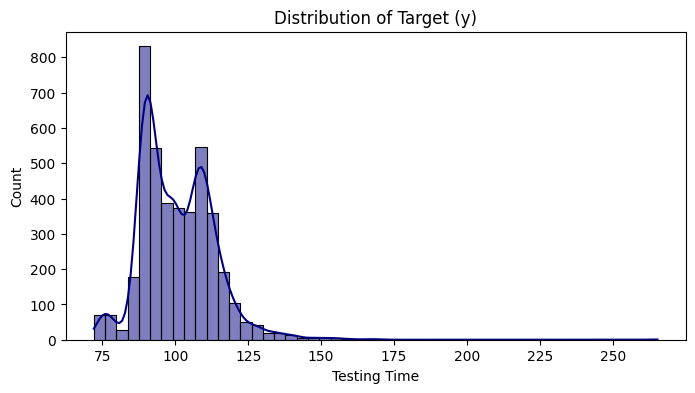

Skewness: 1.206525852242492


In [27]:
plt.figure(figsize=(8,4))
sns.histplot(
    train_df['y'],
    bins=50,
    kde=True,
    color="#000080"  # change bar + kde line color
)
plt.title("Distribution of Target (y)")
plt.xlabel("Testing Time")
plt.show()

# Check skewness
print("Skewness:", train_df['y'].skew())


## Output = Right Skewed outliers present

## Checking for outliers

In [28]:
# Outlier Check for Target 'y' (IQR method)

Q1 = train_df['y'].quantile(0.25)
Q3 = train_df['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = train_df[(train_df['y'] < lower_bound) | (train_df['y'] > upper_bound)]

print("Number of outliers:", len(outliers))
print("Percentage of dataset: {:.2f}%".format(len(outliers) / len(train_df) * 100))
print("Lower bound:", round(lower_bound, 1))
print("Upper bound:", round(upper_bound, 1))
print("\nExtreme values of y (examples):")
print(outliers['y'].sort_values(ascending=False).head())

Number of outliers: 50
Percentage of dataset: 1.19%
Lower bound: 63.5
Upper bound: 136.3

Extreme values of y (examples):
883     265.32
342     169.91
1459    167.45
3133    165.52
1203    160.87
Name: y, dtype: float64


### We found about 50 outliers (1.2% of the data)
- All in the high side / no lower side 
- Since we don't know the real meaning of the features we decided to keep them 
<br> -**This Outliers can represent rare but valid configurations of cars that take longer time on the test bench**<br>
<br>
<br>Extreme values of y (examples):<br>
- 883     265.32
- 342     169.91
- 1459    167.45
- 3133    165.52
- 1203    160.87


- Note: For next iterations of the regression model: Try logaritmic transformation and compare R2

## Example categorical feature distribution (X0)

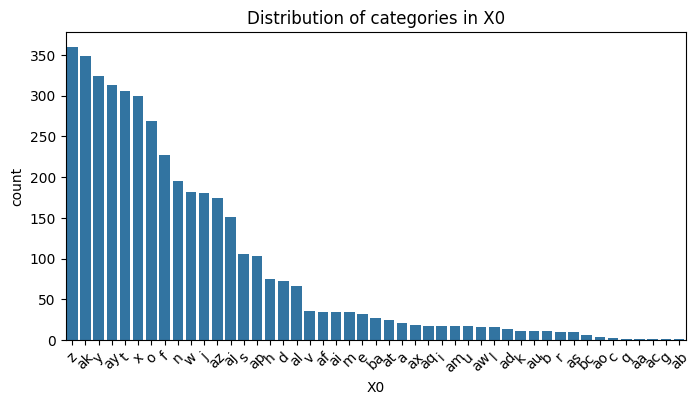

In [29]:
plt.figure(figsize=(8,4))
sns.countplot(x='X0', data=train_df, order=train_df['X0'].value_counts().index)
plt.title("Distribution of categories in X0")
plt.xticks(rotation=45)
plt.show()


## Example numeric feature distribution

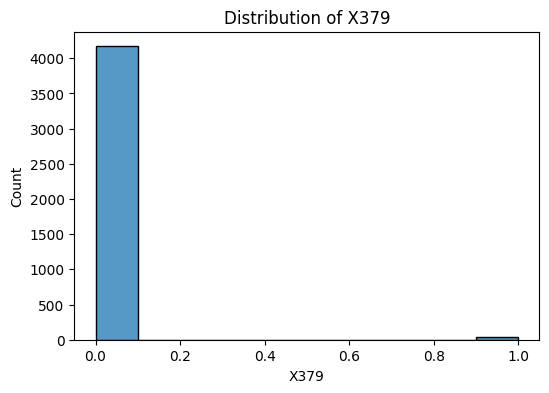

In [30]:
plt.figure(figsize=(6,4))
sns.histplot(train_df['X379'], kde=False, bins=10)
plt.title("Distribution of X379")
plt.show()


# 4. Multivariate Analysis

## Correlations

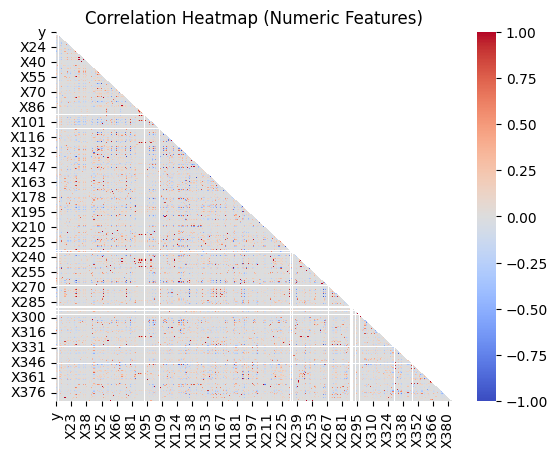

In [31]:
# Define numeric columns if not already defined
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('ID')

# Correlation heatmap for numeric features and target
corr_matrix = train_df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

## Correlation with Target (y)

Top positive correlations with y:
 y       1.000000
X314    0.606005
X261    0.588785
X263    0.379629
X136    0.368177
X275    0.275042
X118    0.272728
X119    0.272728
X51     0.229999
X264    0.228169
Name: y, dtype: float64

Top negative correlations with y:
 X107   NaN
X233   NaN
X235   NaN
X268   NaN
X289   NaN
X290   NaN
X293   NaN
X297   NaN
X330   NaN
X347   NaN
Name: y, dtype: float64


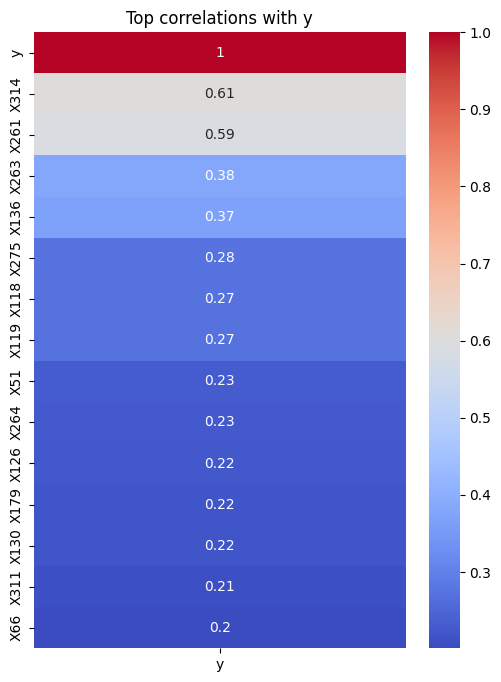

In [32]:
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('ID')

corr = train_df[numeric_cols].corr()['y'].sort_values(ascending=False)
print("Top positive correlations with y:\n", corr.head(10))
print("\nTop negative correlations with y:\n", corr.tail(10))

# Heatmap of top 15 correlated
plt.figure(figsize=(6,8))
sns.heatmap(train_df[numeric_cols].corr()[['y']].sort_values(by='y', ascending=False).head(15),
            annot=True, cmap="coolwarm")
plt.title("Top correlations with y")
plt.show()


## Target vs Categorical feature

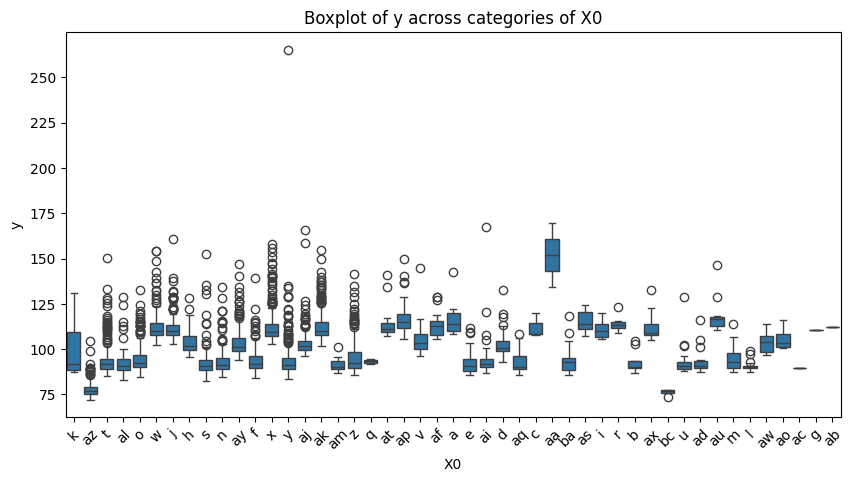

In [33]:
plt.figure(figsize=(10,5))
sns.boxplot(x='X0', y='y', data=train_df)
plt.title("Boxplot of y across categories of X0")
plt.xticks(rotation=45)
plt.show()


## Target vs Numerical Feature

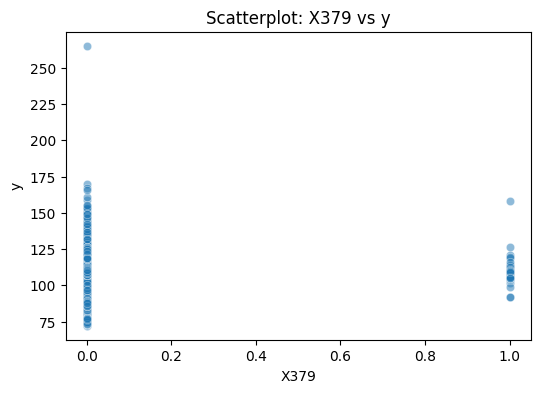

In [34]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='X379', y='y', data=train_df, alpha=0.5)
plt.title("Scatterplot: X379 vs y")
plt.show()


# EDA Conclusions 1 (before transformation of Categorical features)



1. Target (y): Mostly 90–110 sec, but with strong outliers (max 265). Outliers may affect accuracy.

2. Constant features: 12 columns with only 1 unique value: To drop for next steps (X11, X93, X107, X233, X235, X268, X289, X290, X293, X297, X330, X347)

3. Categorical features: Variables like X0, X1 show differences in y across categories: Keep and encode (hot ecoding?)

4. Binary/numeric features: Some are mostly zeros. Maybe Drop for regression? Some weakly correlated with y, maybe still useful for trees.

5. Correlations: No strong linear relationships with y. A tree may be a better fit than linear models

## EDA part 2: Encoding Categorical Variables 
['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'] are categorical columns. 
1. Since we don't know if they are ordinal (oder has a meaning) we can not use a Label encoding (ex=Small, medium, large or C>A). 
2. Since we don't know if they are a ranking (ordinaL) Ex: Educational level we can not use an Ordinal encoding 
3. Becuause The mercedes dataset features are arbitrary labels we ONLY can use One-Hot-Econding (OHE): Creates a binary col for each category (A=1/0, B=1/0...) 
### Necesary for linear regression 
- Recommendable for Trees 
- DO NOT use OHE for ordinal (order has a meaning Ex=S,M,L / Satisfaction level / Stars ratings)


In [35]:
# Define categorical columns
categorical_cols = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']

# rename to OHE and set config /transform the output to a PD dataframe (requires sklearn version older than1.2)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas') 

ohe_transform = ohe.fit_transform(train_df[categorical_cols])

#print the transformed dataframe
print(ohe_transform.head())

   X0_a  X0_aa  X0_ab  X0_ac  X0_ad  X0_af  X0_ai  X0_aj  X0_ak  X0_al  ...  \
0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   X8_p  X8_q  X8_r  X8_s  X8_t  X8_u  X8_v  X8_w  X8_x  X8_y  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 195 columns]


In [36]:
# Combine OHE with original dataframe (excluding original categorical columns)
train_df_ohe = train_df.drop(columns=categorical_cols).join(ohe_transform)
# check result
print(train_df_ohe.head())


   ID       y  X10  X11  X12  X13  X14  X15  X16  X17  ...  X8_p  X8_q  X8_r  \
0   0  130.81    0    0    0    1    0    0    0    0  ...   0.0   0.0   0.0   
1   6   88.53    0    0    0    0    0    0    0    0  ...   0.0   0.0   0.0   
2   7   76.26    0    0    0    0    0    0    0    1  ...   0.0   0.0   0.0   
3   9   80.62    0    0    0    0    0    0    0    0  ...   0.0   0.0   0.0   
4  13   78.02    0    0    0    0    0    0    0    0  ...   0.0   0.0   0.0   

   X8_s  X8_t  X8_u  X8_v  X8_w  X8_x  X8_y  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   1.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 565 columns]


### Transformed DF
Original Number of columns: 378
Number of coulumns after OHE: 565

## New correlation including encoded categorical features

/Users/elab2/Desktop/AI_PM/mercedes/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/elab2/Desktop/AI_PM/mercedes/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top POSITIVE correlations with y:
 X314     0.606005
X261     0.588785
X263     0.379629
X136     0.368177
X0_ak    0.281835
X275     0.275042
X119     0.272728
X118     0.272728
X0_x     0.259727
X51      0.229999
dtype: float64 

Top NEGATIVE correlations with y:
 X127    -0.510620
X279    -0.379629
X232    -0.379629
X29     -0.379629
X0_az   -0.372009
X76     -0.368177
X54     -0.368177
X328    -0.366220
X276    -0.359254
X162    -0.355876
dtype: float64 



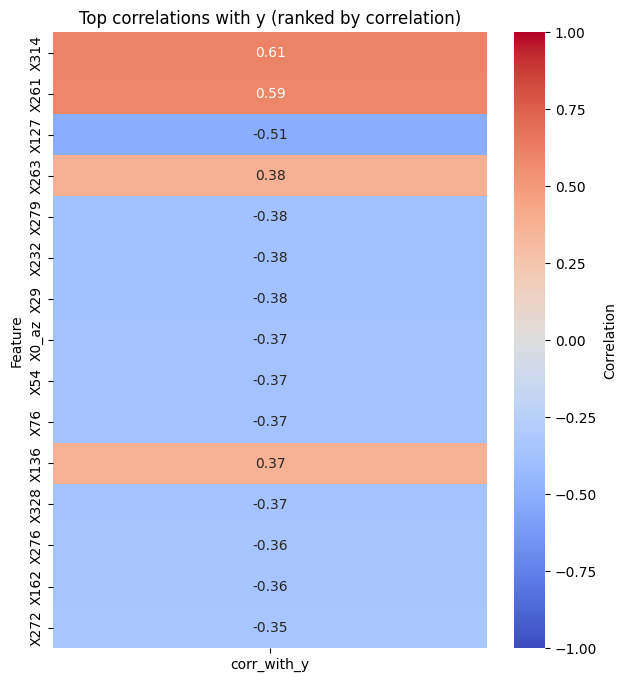

In [38]:
# 1) Pick numeric columns
num_cols = train_df_ohe.select_dtypes(include=np.number).columns.tolist()

# 2) Remove Id and y 
for col in ['ID', 'y']:
    if col in num_cols:
        num_cols.remove(col)

# 3) Correlation of every numeric feature with y (signed)
#    Note: we compute corr only against y, not the full matrix
corr_with_y = train_df_ohe[num_cols].corrwith(train_df_ohe['y']).dropna()

# 4) Report TOP positives and TOP negatives (by signed corr)
top_pos = corr_with_y.sort_values(ascending=False).head(10)
top_neg = corr_with_y.sort_values(ascending=True).head(10)   # most negative at the top

print("Top POSITIVE correlations with y:\n", top_pos, "\n")
print("Top NEGATIVE correlations with y:\n", top_neg, "\n")

# 5) Select the top-K by ABSOLUTE correlation (better for modeling)
K = 15
top_abs_idx = corr_with_y.abs().sort_values(ascending=False).head(K).index

# 6) Build a 1-column “matrix” for a clean heatmap, sorted by corr
corr_for_plot = corr_with_y.loc[top_abs_idx].sort_values(
    key=np.abs, ascending=False
).to_frame(name='corr_with_y')

plt.figure(figsize=(7, 8))
sns.heatmap(
    corr_for_plot,          # single column: corr_with_y
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    cbar_kws={'label': 'Correlation'}
)
plt.title("Top correlations with y (ranked by correlation)")
plt.ylabel("Feature")
plt.xlabel("")
plt.show()


## Output of including new features
- y        1.000000   (trivial, correlation with itself)
- X314     0.606005
- X261     0.588785
- X263     0.379629
- X136     0.368177
- X0_ak    0.281835   ← OHE feature (X0 category “ak”)
- X275     0.275042
- X118     0.272728
- X119     0.272728
- X0_x     0.259727   ← OHE feature (X0 category “x”)

- 

# Conclusions Including encoded categorical features

## 🔎 Correlation Analysis with Encoded Features

- After applying **One-Hot Encoding (OHE)** to the categorical variables, some of the new encoded features show up among the top correlations with the target `y`.  

### Key Findings
- **Top correlated features (positive with `y`):**
  - `X314` (0.61), `X261` (0.59), `X263` (0.38), `X136` (0.37) → original numeric/binary features.  
  - `X0_ak` (0.28), `X0_x` (0.26) → **OHE features from categorical column `X0`**.  

- **Interpretation:**  
  - Certain categories of `X0` (e.g., `ak`, `x`) are **moderately correlated with test bench time**.  
  - This means that cars with these configurations tend to show systematically higher/lower testing times.  
  - These encoded categorical features are **useful predictors** for the model.  

- **Negative correlations:**  
  - Several constant columns (`X107`, `X233`, `X235`, `X268`, `X289`, `X290`, `X293`, `X297`, `X330`, `X347`) returned `NaN` because they never vary.  
  - These features should be **dropped** as they contain no information
